## Introdução

O objetivo desse trabalho é, através da regressão logística e da decision tree, conseguir treinar uma base de dados e ao final poder prever se a pessoa (dependendo de algumas caracteristicas, sendo elas: idade, sexo, pressao sanguinea, nivel de colesterol, diabete, frequencia cardíaca maxima, Exercise Angina, que se refere a dor no peito após a pratica de exercícios e Oldpeak) tem/terá ou não doenças cardíacas. Dessa forma, nos modelos de predição a variável target será a que diz repeito a presença ou não de doenças cardíacas e as features são as demais variáveis citadas anteriormente.

## Importando bibliotecas relevantes

In [174]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

## Realiza a leitura e a limpeza da base de dados

In [140]:
# realiza a leitura da base de dados
df0 = pd.read_csv('heart.csv')

In [141]:
df0.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [142]:
# Altera nomes de colunas e remove os NaNs
df1 = df0.dropna()
df = df1.rename(columns={'Age': 'idade', 'Sex': 'sexo', 'Cholesterol': 'nivel_colesterol', 'HeartDisease': 'doencas_cardiacas', 'RestingBP': 'pressao_sanguinea', 'FastingBS': 'diabete', 'MaxHR': 'frequencia_maxima' })

# substitue letras por numeros
d = {'M': 1, 'F': 0, 'N': 0, 'Y': 1}
df = df.replace(d)

# remove as coluna que não serão utilizadas pois contem varios possiveis valores
df = df.drop(columns=['ChestPainType', 'ST_Slope', 'RestingECG'])
df.head()

,idade,sexo,pressao_sanguinea,nivel_colesterol,diabete,frequencia_maxima,ExerciseAngina,Oldpeak,doencas_cardiacas
0,40,1,140,289,0,172,0,0.0,0
1,49,0,160,180,0,156,0,1.0,1
2,37,1,130,283,0,98,0,0.0,0
3,48,0,138,214,0,108,1,1.5,1
4,54,1,150,195,0,122,0,0.0,0


## Análise exploratoria

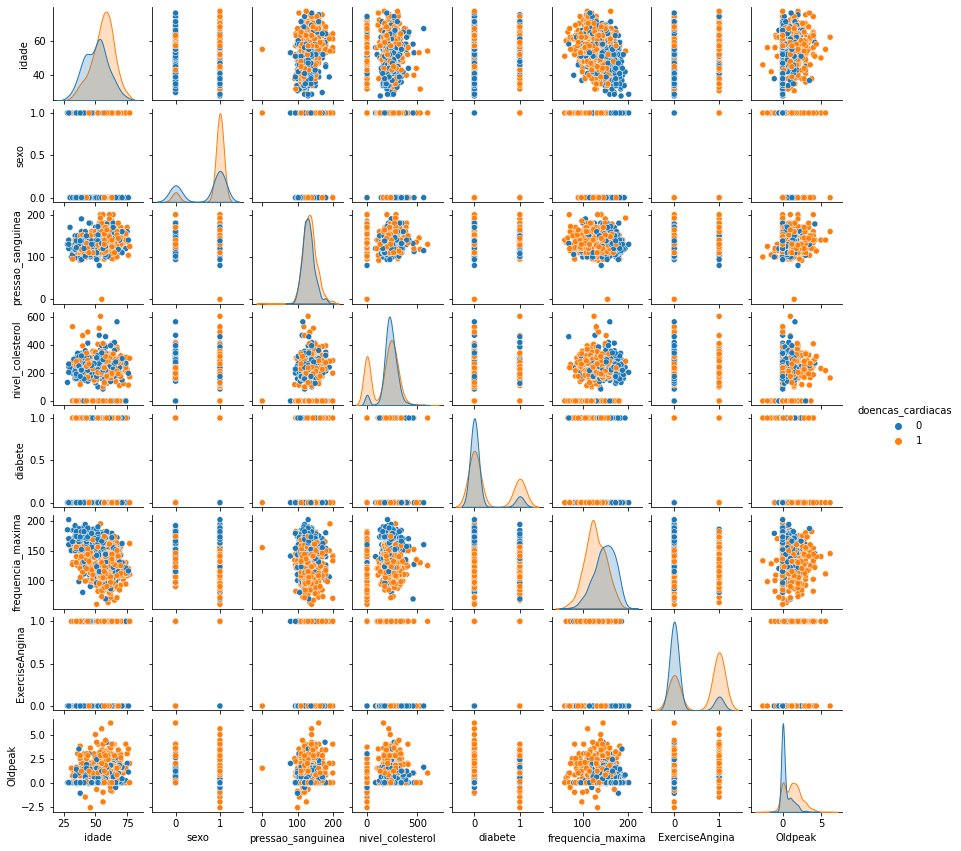

In [143]:
sns.pairplot(df, hue = 'doencas_cardiacas', height=1.5) # cria gráficos juntando colunas do dataframe 

In [144]:
df[['idade', 'pressao_sanguinea', 'nivel_colesterol', 'frequencia_maxima']].describe() # describe somente das variáveis quantitativas

,idade,pressao_sanguinea,nivel_colesterol,frequencia_maxima
count,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368
std,9.432617,18.514154,109.384145,25.460334
min,28.000000,0.000000,0.000000,60.000000
25%,47.000000,120.000000,173.250000,120.000000
50%,54.000000,130.000000,223.000000,138.000000
75%,60.000000,140.000000,267.000000,156.000000
max,77.000000,200.000000,603.000000,202.000000


In [166]:
pd.crosstab(df['sexo'],df['doencas_cardiacas'])

doencas_cardiacas,0,1
sexo,,
0,143,50
1,267,458


In [167]:
pd.crosstab(df['diabete'],df['doencas_cardiacas'])

doencas_cardiacas,0,1
diabete,,
0,366,338
1,44,170


In [168]:
pd.crosstab(df['ExerciseAngina'],df['doencas_cardiacas'])

doencas_cardiacas,0,1
ExerciseAngina,,
0,355,192
1,55,316


In [173]:
# lembrando que '0' é 'não' e '1' é 'sim' para todos esses casos e as tabelas juntam as variaveis qualitativas com o target)

In [149]:
df.info() # Mostra numero total de linhas, colunas e o tipo das variáveis presentes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              918 non-null    int64  
 1   sexo               918 non-null    int64  
 2   pressao_sanguinea  918 non-null    int64  
 3   nivel_colesterol   918 non-null    int64  
 4   diabete            918 non-null    int64  
 5   frequencia_maxima  918 non-null    int64  
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   doencas_cardiacas  918 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 71.7 KB


## Aplicação da técnica de regressão logistica

Resolvemos utilizar a técnica da regressão logística pois a informação que estamos tentando obter é binária e qualitativa, no caso, se a pessoa tem ou não as doenças. As bibliotecas prontas foram utilizadas para dividir a base de dados entre teste e treinamento, para realizar a regressão logistica em si e para plotar alguns graficos e valores interessantes. Esssa técnica segue a seguinte fórmula: P(Y=1) = 1/(1+e^-g(x)). A função g(x) depende das variáveis independentes (features)  e quando essa função tender ao infinito, então  P(Y=1) = 1 e uando ela tender a menos infinito, então  P(Y=1) = 0.

In [150]:
# separação das variáveis
X = df[['idade', 'sexo', 'pressao_sanguinea', 'nivel_colesterol', 'diabete', 'frequencia_maxima', 'ExerciseAngina', 'Oldpeak']]
Y = df['doencas_cardiacas']

In [151]:
# dividir base de dandos entre teste e treinamento através de uma biblioteca pronta
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [152]:
# aplicando a tecnica de regressão logistica utilizando uma biblioteca já existente
logistic_regression= LogisticRegression(random_state=0,max_iter=1000)
logistic_regression.fit(X_train,Y_train)
Y_previsao = logistic_regression.predict(X_test)

## Verificando a acurácia e os falsos positivos e falsos negativos da previsão com regressão logística

In [153]:
# calculando a acurácia 
print('Acurácia: ',metrics.accuracy_score(Y_test, Y_previsao))
plt.show()
print(f'Acurácia em porcentagem aproximadamente:{round(metrics.accuracy_score(Y_test, Y_previsao)*100, 3)}%')

Acurácia:  0.8130434782608695
Acurácia em porcentagem aproximadamente:81.304%


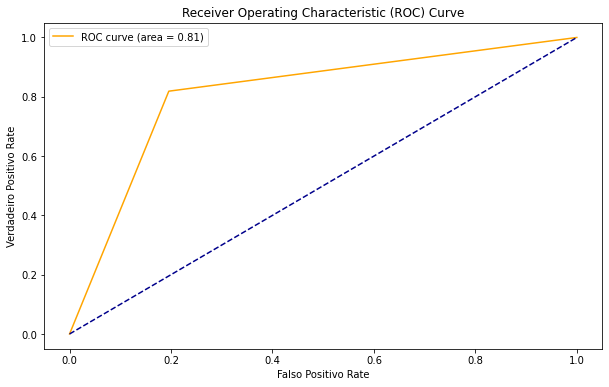

In [154]:
# Plota gráfico que analisa os verdadeiros positivos e verdadeiros negativos
def plot_roc_curve(y_teste, y_previsao, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_teste, y_previsao)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_teste, y_previsao)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Falso Positivo Rate')
    plt.ylabel('Verdadeiro Positivo Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(Y_test, Y_previsao)

Para gráficos desse tipo, áreas entre 0.8 e 0.9 são consideradas muito boas.

In [156]:
matriz = confusion_matrix(Y_test, Y_previsao) # Cria matriz de confusão 

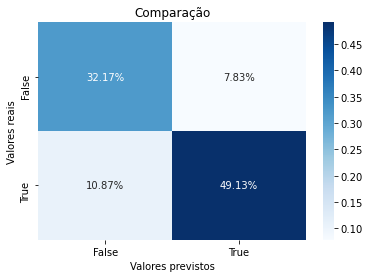

In [157]:
ax = sns.heatmap(matriz/np.sum(matriz), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Comparação')
ax.set_xlabel('Valores previstos')
ax.set_ylabel('Valores reais')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

A matriz de confusão evidencia que a previsão está correta na maioria dos casos, sendo 7.83% considerados com doenças cardíacas quando não deveriam ser e 10.87% considerados sem doenças cardíacas quando deveriam ser. Esses números podem melhorar mas representam bons resultados

In [171]:
print(classification_report(Y_test, Y_previsao)) # mais uma maneira de validar o resultado

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        92
           1       0.86      0.82      0.84       138

    accuracy                           0.81       230
   macro avg       0.81      0.81      0.81       230
weighted avg       0.82      0.81      0.81       230



## Aplicando a técnica 'decision tree'


As bibliotecas prontas foram utilizadas para dividir a base de dados entre teste e treinamento, para realizar a decision tree em si e para plotar alguns graficos e valores interessantes. Esssa técnica leva em conta a relação entre os dados, como uma 'árvore' que vai se ramificando dependendo de valores.

In [158]:
# separação das variáveis
X2 = df[['idade', 'sexo', 'pressao_sanguinea', 'nivel_colesterol', 'diabete', 'frequencia_maxima', 'ExerciseAngina', 'Oldpeak']]
Y2 = df['doencas_cardiacas']

In [160]:
# dividir base de dandos entre teste e treinamento através de uma biblioteca pronta
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,Y2,test_size=0.25,random_state=0)

In [161]:
# Aplica a técnica utilizando uma biblioteca pronta
clf = DecisionTreeClassifier()

clf = clf.fit(X2_train,Y2_train)

Y2_previsao = clf.predict(X2_test)

## Verificando a acurácia e os falsos positivos e falsos negativos da previsão com decision tree

In [162]:
# calculando a acurácia 
print('Acurácia: ',metrics.accuracy_score(Y2_test, Y2_previsao))
plt.show()
print(f'Acurácia em porcentagem aproximadamente:{round(metrics.accuracy_score(Y2_test, Y2_previsao)*100, 3)}%')

Acurácia:  0.7260869565217392
Acurácia em porcentagem aproximadamente:72.609%


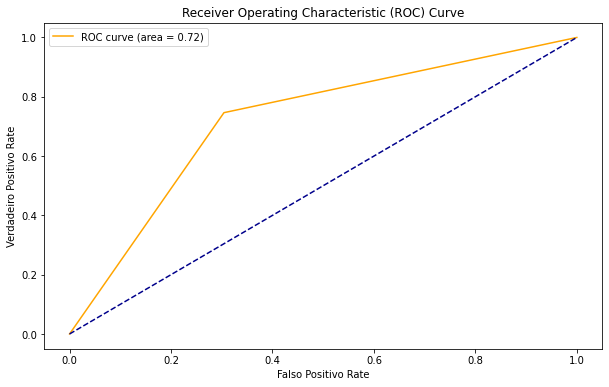

In [163]:
# Plota gráfico que analisa os verdadeiros positivos e verdadeiros negativos
def plot_roc_curve(y_teste, y_previsao, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_teste, y_previsao)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_teste, y_previsao)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Falso Positivo Rate')
    plt.ylabel('Verdadeiro Positivo Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(Y2_test, Y2_previsao)

Para graficos desse tipo, areas de 0.7 são aceitaveis, então podemos considerar a previsão aceitavel

In [164]:
matriz2 = confusion_matrix(Y2_test, Y2_previsao) # Cria a matriz de confusão

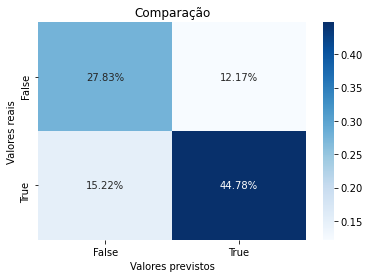

In [165]:
ax = sns.heatmap(matriz2/np.sum(matriz2), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Comparação')
ax.set_xlabel('Valores previstos')
ax.set_ylabel('Valores reais')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

A matriz de confusão evidencia que a previsão está correta na maioria dos casos, sendo 12.77% considerados com doenças cardíacas quando não deveriam ser e 15.22% considerados sem doenças cardíacas quando deveriam ser. Os números não são tão bons apresentando mais erros do que a regressão logística nesse caso.

In [172]:
print(classification_report(Y2_test, Y2_previsao)) # mais uma maneira de validar o resultado

              precision    recall  f1-score   support

           0       0.65      0.70      0.67        92
           1       0.79      0.75      0.77       138

    accuracy                           0.73       230
   macro avg       0.72      0.72      0.72       230
weighted avg       0.73      0.73      0.73       230



## Modelos de Predição

Para os modelos de predição, o primeiro que utilizamos foi a regressão logística, que é usada para modelar a probabilidade de uma determinada classe ou evento existir, no nosso caso, a possibilidade da pessoa te rum problema cardíaco dependendo de alguns fatores.
O segundo é a decision tree que usa vários algoritmos para decidir dividir um nó onde quanto mais nós maior a homogeneidade dos subnós resultantes.

## Referências

https://www.datacamp.com/community/tutorials/decision-tree-classification-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377092&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=Cj0KCQiAhf2MBhDNARIsAKXU5GTJz7kLWdLMYKPiiBPVb9T_EEijoEqZ-haXvS6b_dWAJYPjQUIHGZ4aAobwEALw_wcB
https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=332602034361&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=Cj0KCQiAhf2MBhDNARIsAKXU5GR3MF8RB9La7h6c23AXIolH4xyZxrrCNONai2O5H2Qko0capuksk4gaAjwWEALw_wcB
https://www.sciencedirect.com/science/article/pii/S1556086415306043#:~:text=AREA%20UNDER%20THE%20ROC%20CURVE,-AUC%20is%20an&text=In%20general%2C%20an%20AUC%20of,than%200.9%20is%20considered%20outstanding.

## Conclusão

No geral, ambas as técnicas conseguiram responder a pergunta de maneira positiva, porém a regressão logística obteve mais sucesso. Alguns dos erros podem ter ocorrido pois nem todas as colunas da base de dados foram utilizadas.

## O que cada um fez

O trabalho como um todo foi pensado coletivamente mas o Christian fez a parte do código que diz respeito a regressão logistica, o Victor fez os gráficos que verificam a acurácia dessa técnica e a Luana fez a parte da Decision tree e a análise exploratória. Porém, todos contribuiram em todas as partes e possivelmente fizeram modificações nelas. 